# CVE Visualizer

# Using machine learning models to visualize zero day risk data

In [1]:
# Import libraries from Matplotlib, NumPy, Pandas, Scikit Learn and Seaborn

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import seaborn as sns # Bar chart for accuracy comparison
import pydot # Dot file for decision tree

from IPython.display import Image # Display .png image after converting .dot file
from matplotlib.patches import ConnectionPatch # Create pie chart
from sklearn.preprocessing import LabelEncoder # Encode dataset prior to splitting data
from sklearn.model_selection import train_test_split # Split data into X and y axis for machine learning
from sklearn.model_selection import cross_val_score # Algorithm accuracy measuring
from sklearn.preprocessing import StandardScaler # Scale data so that mean is 0 and standard deviation is 1
from sklearn.linear_model import LogisticRegression # Machine learning algorithm
from sklearn.tree import DecisionTreeClassifier # Machine learning algorithm
from sklearn.naive_bayes import GaussianNB # Machine learning algorithm
from sklearn.metrics import classification_report # Create classification report for decision tree
from sklearn.tree import export_graphviz # Export dot generated for decision tree

# Input & view data file

In [2]:
# Allow user to input dataset file
wild_data = pd.read_csv(input("Enter file name (include .csv file extension): "))

Enter file name (include .csv file extension):  wild.csv


In [3]:
# View first rows of raw data
wild_data.head(10)

,CVE,Vendor,Product,Type,Description,Date Discovered,Date Patched,Advisory,Analysis URL,Root Cause Analysis,Reported By
0,CVE-2024-23296,Apple,iOS,Memory Corruption,Arbitrary kernel r/w in RTKit,NaN,2024-03-06,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
1,CVE-2024-23225,Apple,iOS,Memory Corruption,Out-of-bounds memory access in Kernel,NaN,2024-03-05,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
2,CVE-2024-23222,Apple,WebKit,Memory Corruption,Type confusion,NaN,2024-01-22,https://support.apple.com/en-us/HT214059,NaN,NaN,NaN
3,CVE-2024-0519,Google,Chrome,Memory Corruption,Out-of-bounds memory access,2024-01-11,2024-01-16,https://chromereleases.googleblog.com/2024/01/...,NaN,NaN,NaN
4,CVE-2023-7024,Google,Chrome,Memory Corruption,Heap overflow in WebRTC,2023-12-19,2023-12-20,https://chromereleases.googleblog.com/2023/12/...,NaN,NaN,Clément Lecigne and Vlad Stolyarov of Google's...
5,CVE-2023-33106,Qualcomm,Android,Memory Corruption,Vulnerability in Adreno GPU driver,NaN,2023-12-04,https://docs.qualcomm.com/product/publicresour...,NaN,https://googleprojectzero.github.io/0days-in-t...,Clément Lecigne of Google's Threat Analysis Group
6,CVE-2023-33107,Qualcomm,Android,Memory Corruption,Vulnerability in Adreno GPU driver,NaN,2023-12-04,https://docs.qualcomm.com/product/publicresour...,NaN,https://googleprojectzero.github.io/0days-in-t...,Benoît Sevens of Google's Threat Analysis Grou...
7,CVE-2023-33063,Qualcomm,Android,Memory Corruption,Vulnerability in Adreno GPU driver,NaN,2023-12-04,https://docs.qualcomm.com/product/publicresour...,NaN,NaN,NaN
8,CVE-2023-42916,Apple,WebKit,Info disclosure,Out of bounds read,NaN,2023-11-30,https://support.apple.com/en-us/HT214031,NaN,NaN,Clément Lecigne of Google's Threat Analysis Group
9,CVE-2023-42917,Apple,WebKit,Memory Corruption,Unspecified memory corruption,NaN,2023-11-30,https://support.apple.com/en-us/HT214031,NaN,NaN,Clément Lecigne of Google's Threat Analysis Group


# Clean data

#### Drop columns that contain unusable data

In [4]:
# Cleaning data: Drop unnecessary columns to work with Vendor, Product, and Type columns
wild_data = wild_data.drop(["CVE",
                           "Description",
                           "Date Discovered",
                           "Date Patched",
                           "Advisory",
                           "Analysis URL",
                           "Root Cause Analysis",
                           "Reported By"],
                          axis=1)

In [5]:
# Cleaning data: View first rows of cleaned data
wild_data.head(10)

,Vendor,Product,Type
0,Apple,iOS,Memory Corruption
1,Apple,iOS,Memory Corruption
2,Apple,WebKit,Memory Corruption
3,Google,Chrome,Memory Corruption
4,Google,Chrome,Memory Corruption
5,Qualcomm,Android,Memory Corruption
6,Qualcomm,Android,Memory Corruption
7,Qualcomm,Android,Memory Corruption
8,Apple,WebKit,Info disclosure
9,Apple,WebKit,Memory Corruption


In [6]:
# Cleaning data: check how many rows contain null values
# Notice 4 values in the Type column are null
wild_data.isna().sum()

Vendor     0
Product    0
Type       4
dtype: int64

In [7]:
# Cleaning data: Drop rows where there is a null value
wild_data = wild_data.dropna()

In [8]:
# Cleaning data: check how many rows contain null values
# Notice there are no longer null values
wild_data.isna().sum()

Vendor     0
Product    0
Type       0
dtype: int64

In [9]:
# Cleaning data: Reset the index numbering of rows now that null values have been dropped
wild_data = wild_data.reset_index(drop=True)

In [10]:
# Cleaning data: View first rows of cleaned data
wild_data.head(10)

,Vendor,Product,Type
0,Apple,iOS,Memory Corruption
1,Apple,iOS,Memory Corruption
2,Apple,WebKit,Memory Corruption
3,Google,Chrome,Memory Corruption
4,Google,Chrome,Memory Corruption
5,Qualcomm,Android,Memory Corruption
6,Qualcomm,Android,Memory Corruption
7,Qualcomm,Android,Memory Corruption
8,Apple,WebKit,Info disclosure
9,Apple,WebKit,Memory Corruption


# Normalize data

#### Values with less than 25 total may trigger a warning when split for training & testing
#### To avoid least populated class warning, infrequent types will be grouped together as Other

In [11]:
# View Vendor list before normalization
# Notice Apple and Trend Micro appear twice
np.unique(wild_data["Vendor"])

array(['ARM', 'Adobe', 'Apache', 'Apple', 'Apple ', 'Atlassian',
       'Barracuda', 'Cisco', 'Citrix', 'Facebook', 'Fortinet',
       'Ghostscript', 'Google', 'IBM', 'Linux', 'Microsoft', 'Mozilla',
       'Oracle', 'Qualcomm', 'Samsung', 'Sophos', 'Synacor',
       'Trend Micro', 'TrendMicro', 'VMWare', 'WinRAR'], dtype=object)

In [12]:
# Normalize Vendors: Apple, TrendMicro
wild_data.loc[(wild_data["Vendor"]=="Apple "), "Vendor"] = "Apple"
wild_data.loc[(wild_data["Vendor"]=="Trend Micro"), "Vendor"] = "TrendMicro"

In [13]:
# View Type list before normalization
# Notice infrequent types 
wild_data["Type"].value_counts()

Type
Memory Corruption    220
Logic/Design Flaw     63
Information Leak      11
Use-after-free         6
XSS                    2
UXSS                   2
Info disclosure        1
Unspecified            1
Type Confusion         1
Race Condition         1
Name: count, dtype: int64

In [14]:
# Normalize Types: group infrequent types into Other
wild_data.loc[(wild_data["Type"]=="Information Leak"), "Type"] = "Other"
wild_data.loc[(wild_data["Type"]=="Use-after-free"), "Type"] = "Other"
wild_data.loc[(wild_data["Type"]=="XSS"), "Type"] = "Other"
wild_data.loc[(wild_data["Type"]=="UXSS"), "Type"] = "Other"
wild_data.loc[(wild_data["Type"]=="Info disclosure"), "Type"] = "Other"
wild_data.loc[(wild_data["Type"]=="Unspecified"), "Type"] = "Other"
wild_data.loc[(wild_data["Type"]=="Type Confusion"), "Type"] = "Other"
wild_data.loc[(wild_data["Type"]=="Race Condition"), "Type"] = "Other"

In [15]:
# View Type list after normalization
wild_data["Type"].value_counts()

Type
Memory Corruption    220
Logic/Design Flaw     63
Other                 25
Name: count, dtype: int64

#### (Neagoie & Bourke, 2024)

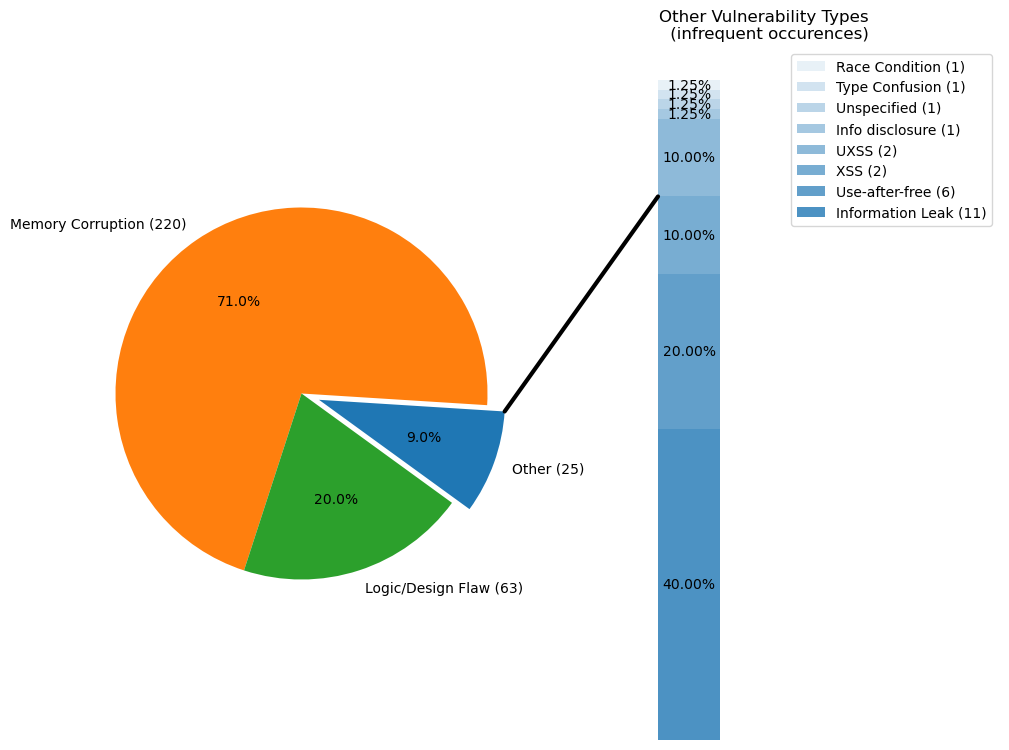

In [16]:
# Create pie chart of normalized Type values

# Make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
fig.subplots_adjust(wspace=0)

# Pie chart parameters
overall_ratios = [.09, .71, .20]
labels = ['Other (25)', 'Memory Corruption (220)', 'Logic/Design Flaw (63)']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[2]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# Bar chart parameters
age_ratios = [.4, .2, .1, .1, .0125, .0125, .0125, .0125]
age_labels = ['Information Leak (11)',
              'Use-after-free (6)',
              'XSS (2)', 'UXSS (2)',
              'Info disclosure (1)',
              'Unspecified (1)',
              'Type Confusion (1)',
              'Race Condition (1)']
bottom = 1
width = .1

# Adding from the top matches the legend
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.1 * j)
    ax2.bar_label(bc, labels=[f"{height:.2%}"], label_type='center')

ax2.set_title('Other Vulnerability Types \n (infrequent occurences)')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 5 * width)

# Draw line using ConnectionPatch
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# Draw connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(3)
ax2.add_artist(con)

plt.show()

#### (Hunter et al., 2024)

#### Vulnerability types are now normalized into 3 categories: Memory Corruption, Logic/Design Flaw, and Other

# Begin Machine Learning

#### Compare accuracy scores of Naive Bayes (Gaussian), Logistic Regression, and Decision Tree Classifier algorithms

In [17]:
# Encode dataframe
def label_encoder(y):
    le = LabelEncoder()
    wild_data[y] = le.fit_transform(wild_data[y])
 
label_list = ["Vendor","Product", "Type"]
 
for l in label_list:
    label_encoder(l)

In [18]:
# Split data into X and y axis
X = wild_data.drop("Type", axis=1)
y = wild_data["Type"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (277, 2)
X_test shape:  (31, 2)
y_train shape:  (277,)
y_test shape:  (31,)


In [19]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [20]:
# Dictionaries to store results for comparison
result_dict_train = {}
result_dict_test = {}

In [21]:
# Naive Bayes Classifier: Gaussian [67%]

gnb = GaussianNB()
accuracies = cross_val_score(gnb, X_train, y_train, cv=5)
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
 
#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",gnb.score(X_test,y_test))

Train Score: 0.7220779220779221
Test Score: 0.7096774193548387


In [22]:
# Store NB results

result_dict_train["Gaussian Naive Bayes: "] = np.mean(accuracies)
result_dict_test["Gaussian Naive Bayes: "] = gnb.score(X_test,y_test)

In [23]:
# Logistic Regression

reg = LogisticRegression()
accuracies = cross_val_score(reg, X_train, y_train, cv=5)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
 
#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",reg.score(X_test,y_test))

Train Score: 0.7293506493506493
Test Score: 0.7096774193548387


In [24]:
# Store LR results

result_dict_train["Logistic Regression: "] = np.mean(accuracies)
result_dict_test["Logistic Regression: "] = reg.score(X_test,y_test)

In [25]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier()
accuracies = cross_val_score(dtc, X_train, y_train, cv=5)
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
 
# Measure accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",dtc.score(X_test,y_test))

Train Score: 0.7362987012987012
Test Score: 0.7741935483870968


In [26]:
# Store DT results

result_dict_train["Decision Tree Classifier: "] = np.mean(accuracies)
result_dict_test["Decision Tree Classifier: "] = dtc.score(X_test,y_test)

In [27]:
# Compare training Scores
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["TrainingScore"])
df_result_train

,TrainingScore
Gaussian Naive Bayes:,0.722078
Logistic Regression:,0.729351
Decision Tree Classifier:,0.736299


In [28]:
# Compare testing Scores
df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["TestingScore"])
df_result_test

,TestingScore
Gaussian Naive Bayes:,0.709677
Logistic Regression:,0.709677
Decision Tree Classifier:,0.774194


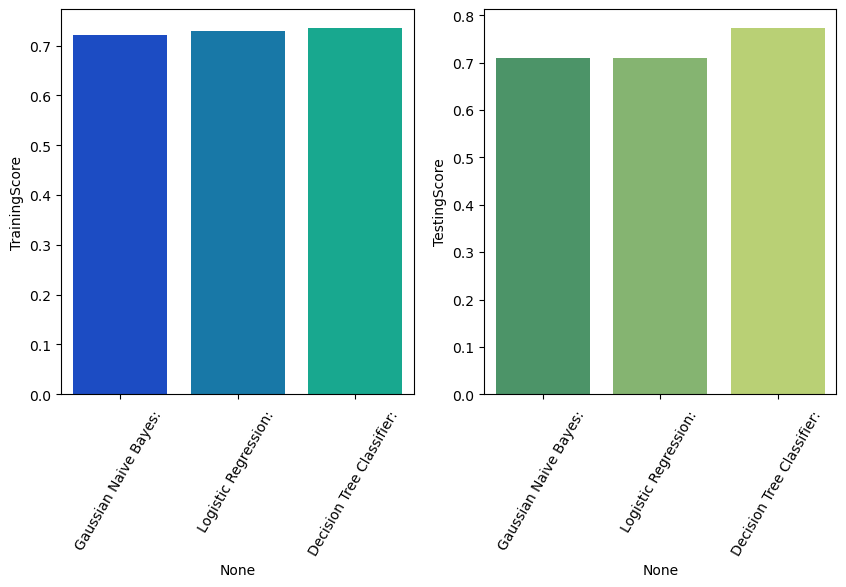

In [29]:
# Visualize comparisons
 
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_train.index, y = df_result_train.TrainingScore, hue = df_result_train.index, legend = False, ax = ax[0], palette = "winter")
sns.barplot(x = df_result_test.index, y = df_result_test.TestingScore, hue = df_result_train.index, legend = False, ax = ax[1],  palette = "summer")
ax[0].tick_params("x", labelrotation=60)
ax[1].tick_params("x", labelrotation=60)

plt.show()

#### (Geeksforgeeks.org, 2024)

#### (Shiksha, 2024)

#### Accuracy scores show consistent results between algorithms

# Begin Model Prediction Making: Decision Tree Model

#### Apply machine learning model (make predictive decisions) and show decision making process (Naive Bayes: Gaussian algorithm is used)

In [30]:
# Allow user to input dataset file
wild_tree = pd.read_csv(input("Enter file name (include .csv file extension): "))

Enter file name (include .csv file extension):  wild.csv


In [31]:
# View first rows of raw data
wild_tree.head(10)

,CVE,Vendor,Product,Type,Description,Date Discovered,Date Patched,Advisory,Analysis URL,Root Cause Analysis,Reported By
0,CVE-2024-23296,Apple,iOS,Memory Corruption,Arbitrary kernel r/w in RTKit,NaN,2024-03-06,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
1,CVE-2024-23225,Apple,iOS,Memory Corruption,Out-of-bounds memory access in Kernel,NaN,2024-03-05,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
2,CVE-2024-23222,Apple,WebKit,Memory Corruption,Type confusion,NaN,2024-01-22,https://support.apple.com/en-us/HT214059,NaN,NaN,NaN
3,CVE-2024-0519,Google,Chrome,Memory Corruption,Out-of-bounds memory access,2024-01-11,2024-01-16,https://chromereleases.googleblog.com/2024/01/...,NaN,NaN,NaN
4,CVE-2023-7024,Google,Chrome,Memory Corruption,Heap overflow in WebRTC,2023-12-19,2023-12-20,https://chromereleases.googleblog.com/2023/12/...,NaN,NaN,Clément Lecigne and Vlad Stolyarov of Google's...
5,CVE-2023-33106,Qualcomm,Android,Memory Corruption,Vulnerability in Adreno GPU driver,NaN,2023-12-04,https://docs.qualcomm.com/product/publicresour...,NaN,https://googleprojectzero.github.io/0days-in-t...,Clément Lecigne of Google's Threat Analysis Group
6,CVE-2023-33107,Qualcomm,Android,Memory Corruption,Vulnerability in Adreno GPU driver,NaN,2023-12-04,https://docs.qualcomm.com/product/publicresour...,NaN,https://googleprojectzero.github.io/0days-in-t...,Benoît Sevens of Google's Threat Analysis Grou...
7,CVE-2023-33063,Qualcomm,Android,Memory Corruption,Vulnerability in Adreno GPU driver,NaN,2023-12-04,https://docs.qualcomm.com/product/publicresour...,NaN,NaN,NaN
8,CVE-2023-42916,Apple,WebKit,Info disclosure,Out of bounds read,NaN,2023-11-30,https://support.apple.com/en-us/HT214031,NaN,NaN,Clément Lecigne of Google's Threat Analysis Group
9,CVE-2023-42917,Apple,WebKit,Memory Corruption,Unspecified memory corruption,NaN,2023-11-30,https://support.apple.com/en-us/HT214031,NaN,NaN,Clément Lecigne of Google's Threat Analysis Group


In [32]:
# Cleaning data: Drop unnecessary columns to work with Vendor, Product, and Type columns
wild_tree = wild_tree.drop(["CVE",
                           "Description",
                           "Date Discovered",
                           "Date Patched",
                           "Advisory",
                           "Analysis URL",
                           "Root Cause Analysis",
                           "Reported By"],
                          axis=1)

In [33]:
# Cleaning data: View first rows of cleaned data
wild_tree.head(10)

,Vendor,Product,Type
0,Apple,iOS,Memory Corruption
1,Apple,iOS,Memory Corruption
2,Apple,WebKit,Memory Corruption
3,Google,Chrome,Memory Corruption
4,Google,Chrome,Memory Corruption
5,Qualcomm,Android,Memory Corruption
6,Qualcomm,Android,Memory Corruption
7,Qualcomm,Android,Memory Corruption
8,Apple,WebKit,Info disclosure
9,Apple,WebKit,Memory Corruption


In [34]:
# Cleaning data: Drop rows where there is a null value
wild_tree = wild_tree.dropna()

In [35]:
# Cleaning data: Reset the index numbering of rows now that null values have been dropped
wild_tree = wild_tree.reset_index(drop=True)

In [36]:
# Cleaning data: View first rows of cleaned data
wild_tree.head(10)

,Vendor,Product,Type
0,Apple,iOS,Memory Corruption
1,Apple,iOS,Memory Corruption
2,Apple,WebKit,Memory Corruption
3,Google,Chrome,Memory Corruption
4,Google,Chrome,Memory Corruption
5,Qualcomm,Android,Memory Corruption
6,Qualcomm,Android,Memory Corruption
7,Qualcomm,Android,Memory Corruption
8,Apple,WebKit,Info disclosure
9,Apple,WebKit,Memory Corruption


In [37]:
# Store cleaned and encoded dataset
df= wild_tree

# Show a randow sample of data
df.sample(10)

,Vendor,Product,Type
36,Apple,WebKit,Memory Corruption
282,Microsoft,Windows Kernel,Memory Corruption
51,ARM,Android,Memory Corruption
256,Apple,WebKit,Memory Corruption
239,Microsoft,Windows,Memory Corruption
147,Microsoft,Exchange Server,Logic/Design Flaw
137,ARM,Android,Memory Corruption
198,Mozilla,Firefox,Logic/Design Flaw
263,Microsoft,Windows Kernel,Memory Corruption
251,Microsoft,Windows,Memory Corruption


In [38]:
# View Vendor list before normalization
# Notice Apple and Trend Micro appear twice
np.unique(wild_tree["Vendor"])

array(['ARM', 'Adobe', 'Apache', 'Apple', 'Apple ', 'Atlassian',
       'Barracuda', 'Cisco', 'Citrix', 'Facebook', 'Fortinet',
       'Ghostscript', 'Google', 'IBM', 'Linux', 'Microsoft', 'Mozilla',
       'Oracle', 'Qualcomm', 'Samsung', 'Sophos', 'Synacor',
       'Trend Micro', 'TrendMicro', 'VMWare', 'WinRAR'], dtype=object)

In [39]:
# Normalize Vendors: Apple, TrendMicro
wild_tree.loc[(wild_tree["Vendor"]=="Apple "), "Vendor"] = "Apple"
wild_tree.loc[(wild_tree["Vendor"]=="Trend Micro"), "Vendor"] = "TrendMicro"

In [40]:
# View Type list before normalization
# Notice infrequent types 
wild_tree["Type"].value_counts()

Type
Memory Corruption    220
Logic/Design Flaw     63
Information Leak      11
Use-after-free         6
XSS                    2
UXSS                   2
Info disclosure        1
Unspecified            1
Type Confusion         1
Race Condition         1
Name: count, dtype: int64

In [41]:
# Normalize Types: group infrequent types into Other
wild_tree.loc[(wild_tree["Type"]=="Information Leak"), "Type"] = "Other"
wild_tree.loc[(wild_tree["Type"]=="Use-after-free"), "Type"] = "Other"
wild_tree.loc[(wild_tree["Type"]=="XSS"), "Type"] = "Other"
wild_tree.loc[(wild_tree["Type"]=="UXSS"), "Type"] = "Other"
wild_tree.loc[(wild_tree["Type"]=="Info disclosure"), "Type"] = "Other"
wild_tree.loc[(wild_tree["Type"]=="Unspecified"), "Type"] = "Other"
wild_tree.loc[(wild_tree["Type"]=="Type Confusion"), "Type"] = "Other"
wild_tree.loc[(wild_tree["Type"]=="Race Condition"), "Type"] = "Other"

In [42]:
# View Type list after normalization
wild_tree["Type"].value_counts()

Type
Memory Corruption    220
Logic/Design Flaw     63
Other                 25
Name: count, dtype: int64

In [43]:
# Encode dataframe
def label_encoder(y):
    le = LabelEncoder()
    wild_tree[y] = le.fit_transform(wild_tree[y])
 
label_list = ["Vendor","Product", "Type"]
 
for l in label_list:
    label_encoder(l)

In [44]:
# Split data

X = wild_tree.drop("Type", axis=1)
y = wild_tree["Type"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2)

In [45]:
# Train the decision tree

# Instantiate classifier
dtc = DecisionTreeClassifier()

# Fit model
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [46]:
# Evaluate model

y_pred = dtc.predict(X_test)
print(classification_report(y_test,y_pred,labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.80      1.00      0.89        47
           2       1.00      0.25      0.40         4

    accuracy                           0.81        62
   macro avg       0.93      0.48      0.53        62
weighted avg       0.85      0.81      0.75        62



In [47]:
# Export as dot file

features = ["Vendors", "Products"]
my_class = ["Logic/Design Flaw", "Memory Corruption", "Other"]

export_graphviz(dtc, 
                out_file='tree.dot', 
                feature_names = features,
                class_names = my_class,
                rounded = True, proportion = False, 
                precision = 2, filled = True)


In [48]:
# Convert dot file to png

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

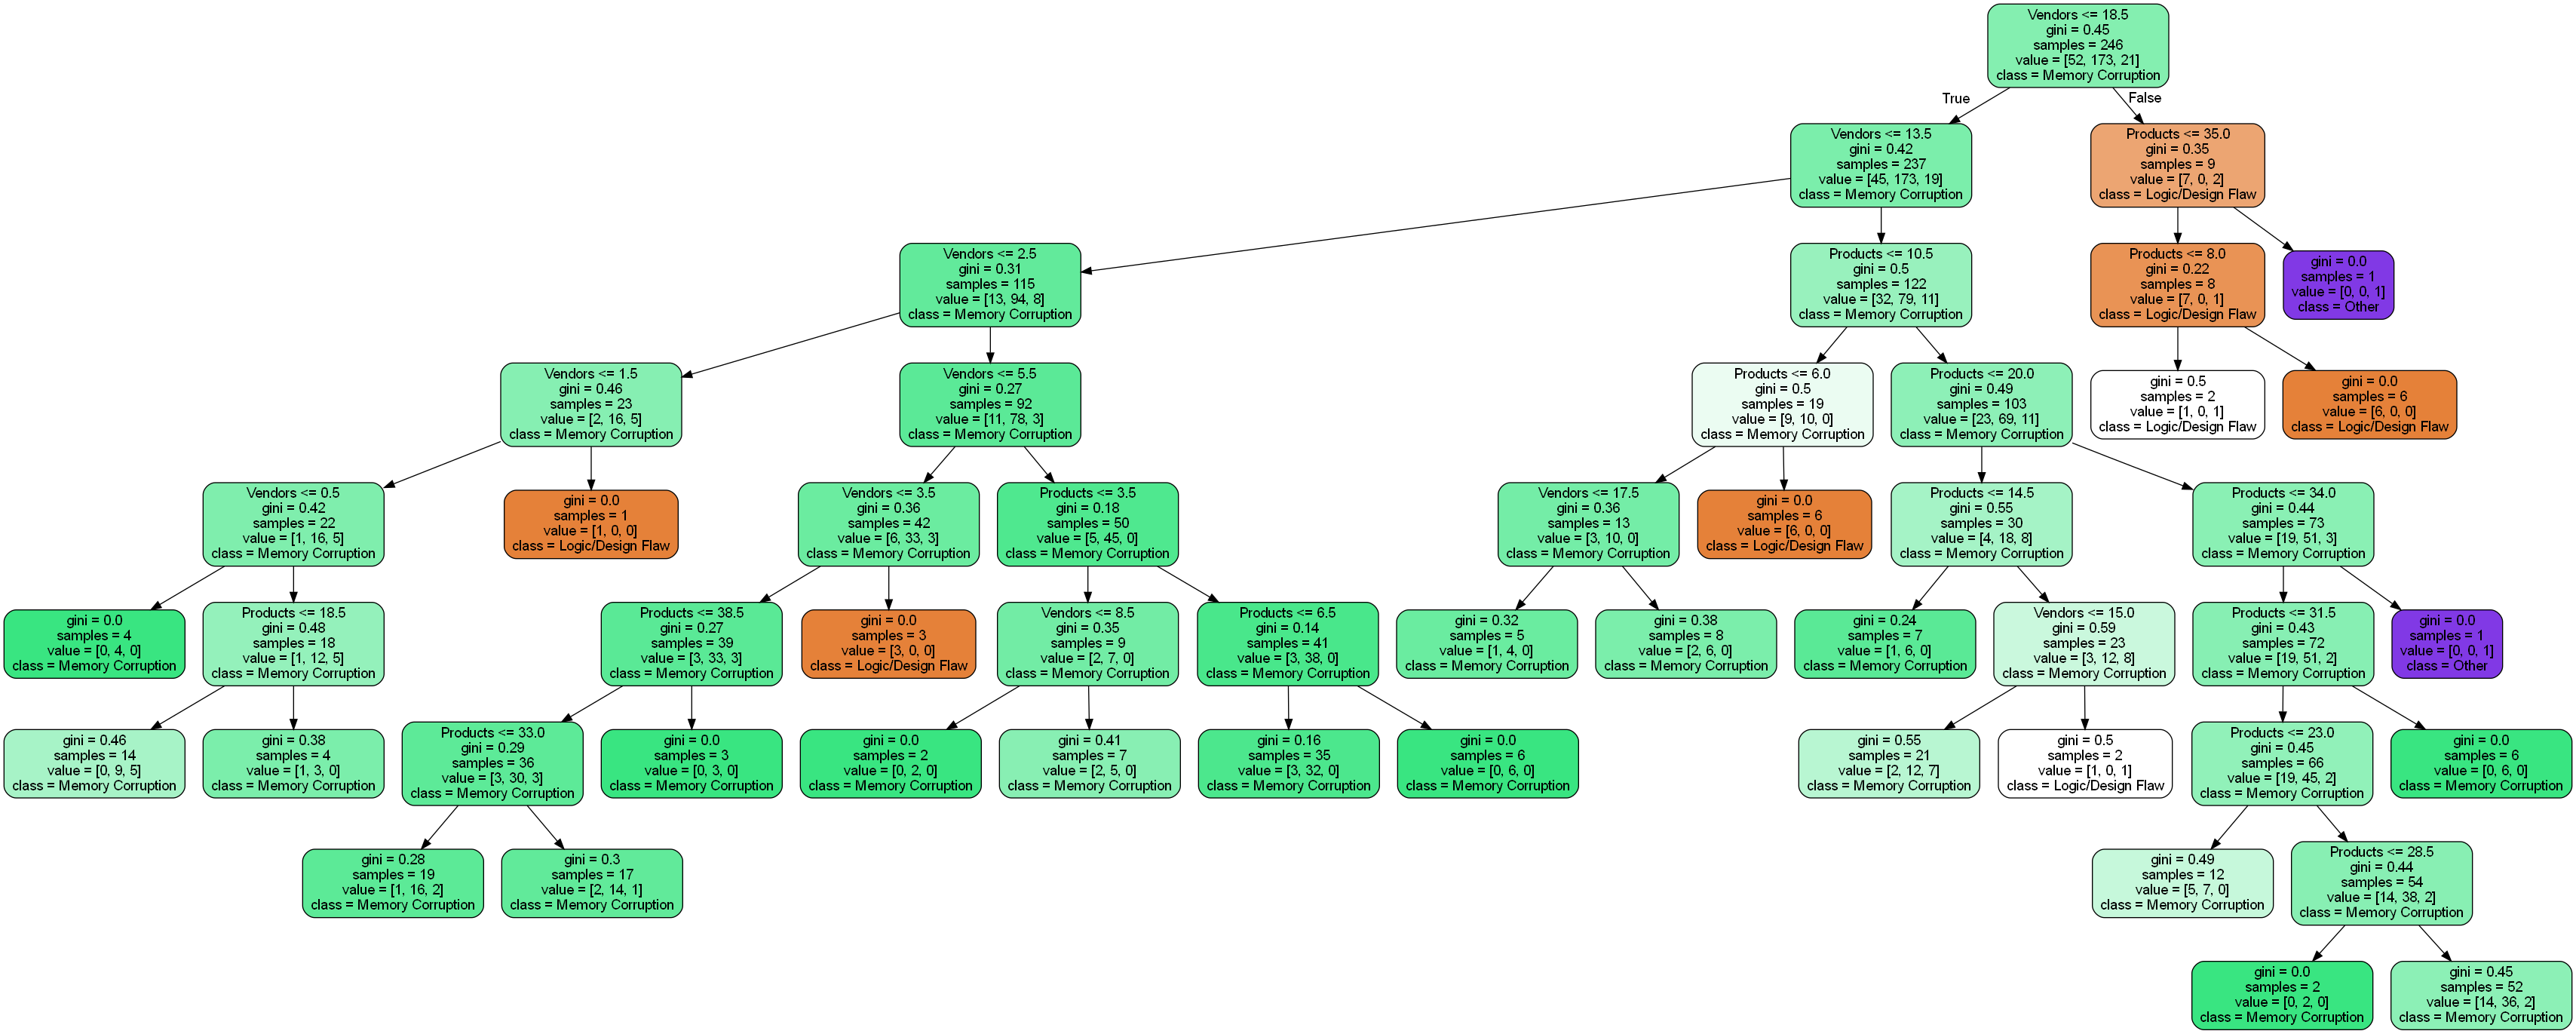

In [49]:
# Show tree

Image(filename = 'tree.png')

#### (Ross, 2024)

#### Decision tree predictions are on par with approximate make-up of vulnerability types:
####     * 71% Memory Corruption (Green)
####     * 20% Logic/Design Flaw (Orange)
####     * 9% Other (Purple)

# Thank you!

### Bibliography

#### Geeksforgeeks.org (2021, June 16). Seaborn.Barplot() method in Python. Retrieved August 17, 2024, from https://www.geeksforgeeks.org/seaborn-barplot-method-in-python/

#### Hunter, J., Dale, D., Firing, E., & Droettboom, M. (2024, August 16). Bar of pie. Matplotlib.org. Retrieved August 16, 2024, from https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html#sphx-glr-gallery-pie-and-polar-charts-bar-of-pie-py

#### Neagoie, A., & Bourke, D. (2024, August 1). Complete A.I. & Machine Learning, Data Science Bootcamp. Udemy.com. Retrieved August 7, 2024, from https://www.udemy.com/course/complete-machine-learning-and-data-science-zero-to-mastery/

#### Ross, M. (2021, September 20). Decision Tree Visualization: A quick tutorial using python for beginners (like me) to construct a decision tree and visualize it. Medium.com. Retrieved August 16, 2024, from https://medium.com/@mer423/decision-tree-visualization-e82dc6d5bf9c

#### Shiksha Online (2023, January 27). Predicting Categorical Data Using Classification Algorithms. Shiksha.com. Retrieved August 14, 2024, from https://www.shiksha.com/online-courses/articles/predicting-categorical-data-using-classification-algorithms/